# 🔬 Nature Inspired Computation - Phase 1 Enhanced
## Sentiment Analysis with Metaheuristic Hyperparameter Optimization

**Dataset**: Sentiment140 (Twitter Sentiment)
**Model**: BiLSTM Neural Network
**Algorithms**: ACO (Feature Selection) + 6 Metaheuristics (Hyperparameter Tuning)

---

## 📥 Task 1: Dataset Loading & Preprocessing

In [2]:
# =========================================
# Setup & Dependencies
# =========================================
!pip install -q nltk tqdm

import os
import pandas as pd
import numpy as np
import re
import nltk
import time
import warnings
warnings.filterwarnings('ignore')

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from tqdm import tqdm

# Download NLTK resources
for pkg in ['stopwords', 'punkt', 'punkt_tab', 'wordnet']:
    try:
        nltk.data.find(f'corpora/{pkg}')
    except LookupError:
        nltk.download(pkg, quiet=True)

tqdm.pandas()
print("✅ Dependencies loaded")

✅ Dependencies loaded


In [3]:
# =========================================
# Kaggle Authentication & Dataset Download
# =========================================
print("--- Authenticating with Kaggle ---")
os.makedirs("/root/.kaggle", exist_ok=True)

if os.path.exists("/content/kaggle.json"):
    os.system("cp /content/kaggle.json /root/.kaggle/")
else:
    raise FileNotFoundError("❌ kaggle.json not found in /content/. Please upload it first!")

os.chmod("/root/.kaggle/kaggle.json", 0o600)
print("✅ Kaggle API key configured successfully.")

print("\n--- Downloading Sentiment140 dataset ---")
os.system("kaggle datasets download -d kazanova/sentiment140 -p /content --force")
os.system("unzip -o /content/sentiment140.zip -d /content/")
print("✅ Dataset downloaded")

--- Authenticating with Kaggle ---
✅ Kaggle API key configured successfully.

--- Downloading Sentiment140 dataset ---
✅ Dataset downloaded


In [4]:
# =========================================
# Load and Preprocess Data
# =========================================
print("--- Loading Data ---")
COL_NAMES = ['target', 'ids', 'date', 'flag', 'user', 'text']
FILEPATH = '/content/training.1600000.processed.noemoticon.csv'

df = pd.read_csv(FILEPATH, encoding='ISO-8859-1', names=COL_NAMES)
df = df.drop_duplicates(subset=['text', 'target'], keep='first')
print(f"Full dataset shape: {df.shape}")

# RESOURCE OPTIMIZATION: Sample 15000 for faster training
SAMPLE_SIZE = 15000
df = df.sample(n=SAMPLE_SIZE, random_state=42)
print(f"Sampled dataset shape: {df.shape}")

# Preprocessing functions
def basic_text_cleaning(text):
    text = text.lower()
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'@[^\s]+', '', text)
    text = re.sub(r'#', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def tokenize_lemmatize_stopwords(text, stop_words, lemmatizer):
    if not isinstance(text, str):
        return ""
    tokens = word_tokenize(text)
    lemmas = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop_words and len(tok) > 2]
    return ' '.join(lemmas)

# Apply preprocessing
print("\n--- Preprocessing ---")
df['text_cleaned'] = df['text'].progress_apply(basic_text_cleaning)

stop_words = set(stopwords.words('english'))
stop_words.update(['im', 'u', 'ur', 'like', 'get', 'go', 'dont'])
lemmatizer = WordNetLemmatizer()

df['text_final'] = df['text_cleaned'].progress_apply(
    lambda t: tokenize_lemmatize_stopwords(t, stop_words, lemmatizer)
)

df['target_encoded'] = df['target'].replace(4, 1)
df = df[df['text_final'] != '']
print(f"✅ Final dataset shape: {df.shape}")

# Split data
X = df['text_final']
y = df['target_encoded']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Train: {len(X_train)} | Val: {len(X_val)} | Test: {len(X_test)}")

--- Loading Data ---
Full dataset shape: (1583691, 6)
Sampled dataset shape: (15000, 6)

--- Preprocessing ---


100%|██████████| 15000/15000 [00:10<00:00, 1393.77it/s]


✅ Final dataset shape: (14901, 9)
Train: 10430 | Val: 2235 | Test: 2236


## 🔢 Task 2: TF-IDF Vectorization

✅ TF-IDF matrix shape: (10430, 5000)


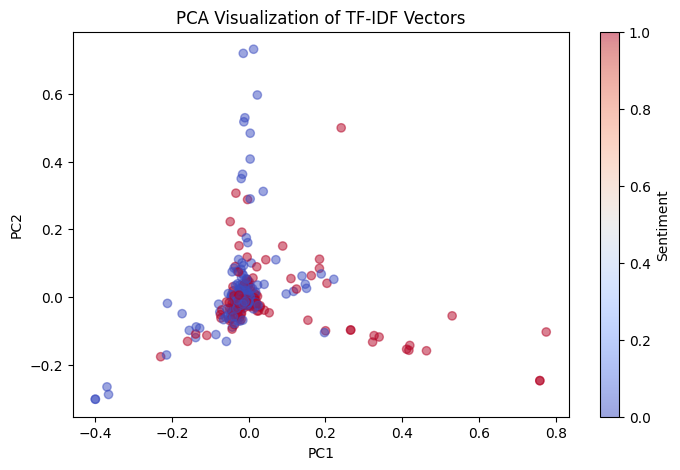

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# TF-IDF
max_features = 5000
vectorizer = TfidfVectorizer(max_features=max_features, stop_words='english')
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

print(f"✅ TF-IDF matrix shape: {X_train_tfidf.shape}")

# PCA Visualization
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_train_tfidf[:500].toarray())

plt.figure(figsize=(8,5))
plt.scatter(X_pca[:,0], X_pca[:,1], c=y_train[:500], cmap='coolwarm', alpha=0.5)
plt.title("PCA Visualization of TF-IDF Vectors")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.colorbar(label='Sentiment')
plt.show()

## 🧠 Task 3: Baseline BiLSTM Model

In [6]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import accuracy_score, f1_score, classification_report

# Tokenization for neural network
MAX_WORDS = 5000
MAX_LEN = 50

tokenizer_nn = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer_nn.fit_on_texts(X_train)

X_train_seq = pad_sequences(tokenizer_nn.texts_to_sequences(X_train), maxlen=MAX_LEN)
X_val_seq = pad_sequences(tokenizer_nn.texts_to_sequences(X_val), maxlen=MAX_LEN)
X_test_seq = pad_sequences(tokenizer_nn.texts_to_sequences(X_test), maxlen=MAX_LEN)

y_train_arr = y_train.values
y_val_arr = y_val.values
y_test_arr = y_test.values

print(f"Train sequences shape: {X_train_seq.shape}")

Train sequences shape: (10430, 50)


In [7]:
# Build and train baseline model
def build_bilstm(embedding_dim=64, lstm_units=64, dropout_rate=0.8, learning_rate=0.9):
    model = Sequential([
        Embedding(MAX_WORDS, embedding_dim, input_length=MAX_LEN),
        Bidirectional(LSTM(lstm_units, return_sequences=False)),
        Dropout(dropout_rate),
        Dense(32, activation='relu'),
        Dropout(dropout_rate/2),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        metrics=['accuracy']
    )
    return model

# Train baseline
print("\n--- Training Baseline Model ---")
baseline_model = build_bilstm()
baseline_history = baseline_model.fit(
    X_train_seq, y_train_arr,
    validation_data=(X_val_seq, y_val_arr),
    epochs=3, batch_size=64, verbose=1
)

# Evaluate
y_pred = (baseline_model.predict(X_test_seq) > 0.5).astype(int)
baseline_acc = accuracy_score(y_test_arr, y_pred)
baseline_f1 = f1_score(y_test_arr, y_pred)

print(f"\n✅ Baseline Accuracy: {baseline_acc:.4f}")
print(f"✅ Baseline F1-Score: {baseline_f1:.4f}")


--- Training Baseline Model ---


NameError: name 'Sequential' is not defined

## 🐜 Task 4: Feature Selection using ACO

In [ ]:
from sklearn.linear_model import LogisticRegression

feature_names = np.array(vectorizer.get_feature_names_out())

def evaluate_subset(subset_indices, X_train, y_train, X_val, y_val):
    if len(subset_indices) == 0:
        return 0
    model = LogisticRegression(max_iter=300, n_jobs=-1)
    model.fit(X_train[:, subset_indices], y_train)
    preds = model.predict(X_val[:, subset_indices])
    return accuracy_score(y_val, preds)

def ant_colony_feature_selection(n_features, X_train, y_train, X_val, y_val,
                                  n_ants=5, n_iter=3, evap_rate=0.3):
    pheromone = np.ones(n_features)
    best_subset, best_acc = [], 0

    for it in range(n_iter):
        print(f"ACO Iteration {it+1}/{n_iter}")
        all_subsets, all_accuracies = [], []

        for ant in range(n_ants):
            probs = pheromone / np.sum(pheromone)
            chosen = np.random.rand(n_features) < probs
            subset = np.where(chosen)[0]

            if len(subset) < 10:
                subset = np.random.choice(n_features, size=50, replace=False)

            acc = evaluate_subset(subset, X_train, y_train, X_val, y_val)
            all_subsets.append(subset)
            all_accuracies.append(acc)

        best_idx = np.argmax(all_accuracies)
        iteration_best_subset = all_subsets[best_idx]
        iteration_best_acc = all_accuracies[best_idx]

        pheromone = (1 - evap_rate) * pheromone
        pheromone[iteration_best_subset] += evap_rate * iteration_best_acc

        if iteration_best_acc > best_acc:
            best_acc = iteration_best_acc
            best_subset = iteration_best_subset

        print(f"  Best this iteration: {iteration_best_acc:.4f}, Global best: {best_acc:.4f}")

    return best_subset, best_acc

# Run ACO
print("\n--- Running ACO Feature Selection ---")
start_time = time.time()
selected_indices, aco_best_acc = ant_colony_feature_selection(
    X_train_tfidf.shape[1],
    X_train_tfidf.toarray(), y_train.values,
    X_val_tfidf.toarray(), y_val.values,
    n_ants=5, n_iter=3
)
aco_time = time.time() - start_time

print(f"\n✅ ACO selected {len(selected_indices)} features")
print(f"ACO Validation Accuracy: {aco_best_acc:.4f}")
print(f"ACO Time: {aco_time:.2f}s")

---
# 🚀 Tasks 5-10: Metaheuristic Hyperparameter Optimization

We now apply **6 metaheuristic algorithms** to optimize BiLSTM hyperparameters:
- `lstm_units` ∈ [32, 64, 128]
- `dropout_rate` ∈ [0.2, 0.5]
- `learning_rate` ∈ [0.001, 0.01]

---

In [ ]:
# =========================================
# Common Fitness Function for All Algorithms
# =========================================

# Hyperparameter bounds
PARAM_BOUNDS = {
    'lstm_units': [32, 64, 128],
    'dropout_rate': (0.2, 0.5),
    'learning_rate': (0.001, 0.01)
}

def decode_solution(solution):
    """Convert continuous solution to hyperparameters"""
    lstm_idx = int(solution[0] * len(PARAM_BOUNDS['lstm_units']))
    lstm_idx = min(lstm_idx, len(PARAM_BOUNDS['lstm_units']) - 1)
    lstm_units = PARAM_BOUNDS['lstm_units'][lstm_idx]

    dropout_rate = PARAM_BOUNDS['dropout_rate'][0] + solution[1] * (
        PARAM_BOUNDS['dropout_rate'][1] - PARAM_BOUNDS['dropout_rate'][0]
    )

    learning_rate = PARAM_BOUNDS['learning_rate'][0] + solution[2] * (
        PARAM_BOUNDS['learning_rate'][1] - PARAM_BOUNDS['learning_rate'][0]
    )

    return int(lstm_units), float(dropout_rate), float(learning_rate)

def fitness_function(solution):
    """Train model with given hyperparameters and return validation accuracy"""
    lstm_units, dropout_rate, learning_rate = decode_solution(solution)

    tf.keras.backend.clear_session()
    model = build_bilstm(
        embedding_dim=64,
        lstm_units=lstm_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    model.fit(
        X_train_seq, y_train_arr,
        validation_data=(X_val_seq, y_val_arr),
        epochs=2, batch_size=64, verbose=0
    )

    y_pred = (model.predict(X_val_seq, verbose=0) > 0.5).astype(int)
    acc = accuracy_score(y_val_arr, y_pred)
    return acc

# Store results for comparison
RESULTS = {
    'Algorithm': [],
    'Best_Accuracy': [],
    'Best_LSTM_Units': [],
    'Best_Dropout': [],
    'Best_LR': [],
    'Time_Seconds': []
}

print("✅ Fitness function ready")

## 🔵 Task 5: Particle Swarm Optimization (PSO)

In [ ]:
def pso_optimize(n_particles=50, n_iterations=3, c1=1.5, c2=1.5, w=0.7):
    """Particle Swarm Optimization for hyperparameter tuning"""
    dim = 3  # lstm_units, dropout, learning_rate

    # Initialize particles
    particles = np.random.rand(n_particles, dim)
    velocities = np.random.rand(n_particles, dim) * 0.1
    personal_best = particles.copy()
    personal_best_scores = np.zeros(n_particles)

    # Evaluate initial positions
    for i in range(n_particles):
        personal_best_scores[i] = fitness_function(particles[i])

    global_best_idx = np.argmax(personal_best_scores)
    global_best = personal_best[global_best_idx].copy()
    global_best_score = personal_best_scores[global_best_idx]

    print(f"PSO Initial best: {global_best_score:.4f}")

    for iteration in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(dim), np.random.rand(dim)

            velocities[i] = (
                w * velocities[i] +
                c1 * r1 * (personal_best[i] - particles[i]) +
                c2 * r2 * (global_best - particles[i])
            )

            particles[i] = np.clip(particles[i] + velocities[i], 0, 1)

            score = fitness_function(particles[i])

            if score > personal_best_scores[i]:
                personal_best[i] = particles[i].copy()
                personal_best_scores[i] = score

                if score > global_best_score:
                    global_best = particles[i].copy()
                    global_best_score = score

        print(f"  Iteration {iteration+1}: Best = {global_best_score:.4f}")

    return global_best, global_best_score

# Run PSO
print("\n--- Task 5: PSO Hyperparameter Optimization ---")
start_time = time.time()
pso_solution, pso_acc = pso_optimize(n_particles=5, n_iterations=3)
pso_time = time.time() - start_time

lstm, dropout, lr = decode_solution(pso_solution)
RESULTS['Algorithm'].append('PSO')
RESULTS['Best_Accuracy'].append(pso_acc)
RESULTS['Best_LSTM_Units'].append(lstm)
RESULTS['Best_Dropout'].append(round(dropout, 4))
RESULTS['Best_LR'].append(round(lr, 6))
RESULTS['Time_Seconds'].append(round(pso_time, 2))

print(f"\n✅ PSO Best: Acc={pso_acc:.4f}, LSTM={lstm}, Dropout={dropout:.3f}, LR={lr:.6f}")
print(f"Time: {pso_time:.2f}s")


--- Task 5: PSO Hyperparameter Optimization ---
PSO Initial best: 0.7128
  Iteration 1: Best = 0.7181
  Iteration 2: Best = 0.7181
  Iteration 3: Best = 0.7181

✅ PSO Best: Acc=0.7181, LSTM=64, Dropout=0.448, LR=0.008564
Time: 158.03s


## 🧬 Task 6: Genetic Algorithm (GA)

In [ ]:
def genetic_algorithm(pop_size=50, n_generations=3, mutation_rate=0.1, crossover_rate=0.8):
    """Genetic Algorithm for hyperparameter tuning"""
    dim = 3

    # Initialize population
    population = np.random.rand(pop_size, dim)
    fitness_scores = np.array([fitness_function(ind) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_solution = population[best_idx].copy()
    best_score = fitness_scores[best_idx]

    print(f"GA Initial best: {best_score:.4f}")

    for gen in range(n_generations):
        # Selection (tournament)
        new_population = []
        for _ in range(pop_size):
            idx1, idx2 = np.random.choice(pop_size, 2, replace=False)
            winner = population[idx1] if fitness_scores[idx1] > fitness_scores[idx2] else population[idx2]
            new_population.append(winner.copy())

        # Crossover
        for i in range(0, pop_size-1, 2):
            if np.random.rand() < crossover_rate:
                point = np.random.randint(1, dim)
                new_population[i][point:], new_population[i+1][point:] = \
                    new_population[i+1][point:].copy(), new_population[i][point:].copy()

        # Mutation
        for i in range(pop_size):
            for j in range(dim):
                if np.random.rand() < mutation_rate:
                    new_population[i][j] = np.random.rand()

        population = np.array(new_population)
        population = np.clip(population, 0, 1)

        # Evaluate
        fitness_scores = np.array([fitness_function(ind) for ind in population])

        gen_best_idx = np.argmax(fitness_scores)
        if fitness_scores[gen_best_idx] > best_score:
            best_solution = population[gen_best_idx].copy()
            best_score = fitness_scores[gen_best_idx]

        print(f"  Generation {gen+1}: Best = {best_score:.4f}")

    return best_solution, best_score

# Run GA
print("\n--- Task 6: Genetic Algorithm Optimization ---")
start_time = time.time()
ga_solution, ga_acc = genetic_algorithm(pop_size=5, n_generations=3)
ga_time = time.time() - start_time

lstm, dropout, lr = decode_solution(ga_solution)
RESULTS['Algorithm'].append('GA')
RESULTS['Best_Accuracy'].append(ga_acc)
RESULTS['Best_LSTM_Units'].append(lstm)
RESULTS['Best_Dropout'].append(round(dropout, 4))
RESULTS['Best_LR'].append(round(lr, 6))
RESULTS['Time_Seconds'].append(round(ga_time, 2))

print(f"\n✅ GA Best: Acc={ga_acc:.4f}, LSTM={lstm}, Dropout={dropout:.3f}, LR={lr:.6f}")
print(f"Time: {ga_time:.2f}s")


--- Task 6: Genetic Algorithm Optimization ---
GA Initial best: 0.7078
  Generation 1: Best = 0.7110
  Generation 2: Best = 0.7110
  Generation 3: Best = 0.7213

✅ GA Best: Acc=0.7213, LSTM=128, Dropout=0.466, LR=0.007986
Time: 153.13s


## 🐺 Task 7: Grey Wolf Optimizer (GWO)

In [ ]:
def grey_wolf_optimizer(n_wolves=5, n_iterations=3):
    """Grey Wolf Optimizer for hyperparameter tuning"""
    dim = 3

    # Initialize wolves
    wolves = np.random.rand(n_wolves, dim)
    fitness_scores = np.array([fitness_function(w) for w in wolves])

    # Sort to find alpha, beta, delta
    sorted_idx = np.argsort(fitness_scores)[::-1]
    alpha, beta, delta = wolves[sorted_idx[0]], wolves[sorted_idx[1]], wolves[sorted_idx[2]]
    alpha_score = fitness_scores[sorted_idx[0]]

    print(f"GWO Initial alpha score: {alpha_score:.4f}")

    for iteration in range(n_iterations):
        a = 2 - iteration * (2 / n_iterations)  # Linearly decreasing

        for i in range(n_wolves):
            for j in range(dim):
                r1, r2 = np.random.rand(), np.random.rand()
                A1, C1 = 2 * a * r1 - a, 2 * r2
                D_alpha = abs(C1 * alpha[j] - wolves[i][j])
                X1 = alpha[j] - A1 * D_alpha

                r1, r2 = np.random.rand(), np.random.rand()
                A2, C2 = 2 * a * r1 - a, 2 * r2
                D_beta = abs(C2 * beta[j] - wolves[i][j])
                X2 = beta[j] - A2 * D_beta

                r1, r2 = np.random.rand(), np.random.rand()
                A3, C3 = 2 * a * r1 - a, 2 * r2
                D_delta = abs(C3 * delta[j] - wolves[i][j])
                X3 = delta[j] - A3 * D_delta

                wolves[i][j] = np.clip((X1 + X2 + X3) / 3, 0, 1)

        # Evaluate and update hierarchy
        fitness_scores = np.array([fitness_function(w) for w in wolves])
        sorted_idx = np.argsort(fitness_scores)[::-1]

        if fitness_scores[sorted_idx[0]] > alpha_score:
            alpha = wolves[sorted_idx[0]].copy()
            alpha_score = fitness_scores[sorted_idx[0]]
        beta = wolves[sorted_idx[1]].copy()
        delta = wolves[sorted_idx[2]].copy()

        print(f"  Iteration {iteration+1}: Alpha = {alpha_score:.4f}")

    return alpha, alpha_score

# Run GWO
print("\n--- Task 7: Grey Wolf Optimizer ---")
start_time = time.time()
gwo_solution, gwo_acc = grey_wolf_optimizer(n_wolves=5, n_iterations=3)
gwo_time = time.time() - start_time

lstm, dropout, lr = decode_solution(gwo_solution)
RESULTS['Algorithm'].append('GWO')
RESULTS['Best_Accuracy'].append(gwo_acc)
RESULTS['Best_LSTM_Units'].append(lstm)
RESULTS['Best_Dropout'].append(round(dropout, 4))
RESULTS['Best_LR'].append(round(lr, 6))
RESULTS['Time_Seconds'].append(round(gwo_time, 2))

print(f"\n✅ GWO Best: Acc={gwo_acc:.4f}, LSTM={lstm}, Dropout={dropout:.3f}, LR={lr:.6f}")
print(f"Time: {gwo_time:.2f}s")


--- Task 7: Grey Wolf Optimizer ---
GWO Initial alpha score: 0.7092
  Iteration 1: Alpha = 0.7186
  Iteration 2: Alpha = 0.7186
  Iteration 3: Alpha = 0.7186

✅ GWO Best: Acc=0.7186, LSTM=128, Dropout=0.378, LR=0.009518
Time: 152.19s


## 🐋 Task 8: Whale Optimization Algorithm (WOA)

In [ ]:
def whale_optimization(n_whales=50, n_iterations=3):
    """Whale Optimization Algorithm for hyperparameter tuning"""
    dim = 3

    # Initialize whales
    whales = np.random.rand(n_whales, dim)
    fitness_scores = np.array([fitness_function(w) for w in whales])

    best_idx = np.argmax(fitness_scores)
    best_whale = whales[best_idx].copy()
    best_score = fitness_scores[best_idx]

    print(f"WOA Initial best: {best_score:.4f}")

    for iteration in range(n_iterations):
        a = 2 - iteration * (2 / n_iterations)

        for i in range(n_whales):
            r = np.random.rand()
            A = 2 * a * r - a
            C = 2 * r
            l = np.random.uniform(-1, 1)
            p = np.random.rand()
            b = 1  # Spiral constant

            if p < 0.5:
                if abs(A) < 1:
                    # Encircling prey
                    D = abs(C * best_whale - whales[i])
                    whales[i] = best_whale - A * D
                else:
                    # Search for prey
                    rand_idx = np.random.randint(n_whales)
                    rand_whale = whales[rand_idx]
                    D = abs(C * rand_whale - whales[i])
                    whales[i] = rand_whale - A * D
            else:
                # Spiral updating
                D = abs(best_whale - whales[i])
                whales[i] = D * np.exp(b * l) * np.cos(2 * np.pi * l) + best_whale

            whales[i] = np.clip(whales[i], 0, 1)

        # Evaluate
        fitness_scores = np.array([fitness_function(w) for w in whales])
        iter_best_idx = np.argmax(fitness_scores)

        if fitness_scores[iter_best_idx] > best_score:
            best_whale = whales[iter_best_idx].copy()
            best_score = fitness_scores[iter_best_idx]

        print(f"  Iteration {iteration+1}: Best = {best_score:.4f}")

    return best_whale, best_score

# Run WOA
print("\n--- Task 8: Whale Optimization Algorithm ---")
start_time = time.time()
woa_solution, woa_acc = whale_optimization(n_whales=5, n_iterations=3)
woa_time = time.time() - start_time

lstm, dropout, lr = decode_solution(woa_solution)
RESULTS['Algorithm'].append('WOA')
RESULTS['Best_Accuracy'].append(woa_acc)
RESULTS['Best_LSTM_Units'].append(lstm)
RESULTS['Best_Dropout'].append(round(dropout, 4))
RESULTS['Best_LR'].append(round(lr, 6))
RESULTS['Time_Seconds'].append(round(woa_time, 2))

print(f"\n✅ WOA Best: Acc={woa_acc:.4f}, LSTM={lstm}, Dropout={dropout:.3f}, LR={lr:.6f}")
print(f"Time: {woa_time:.2f}s")

## 🔀 Task 9: Differential Evolution (DE)

In [ ]:
def differential_evolution(pop_size=50, n_generations=30, F=0.8, CR=0.7):
    """Differential Evolution for hyperparameter tuning"""
    dim = 3

    # Initialize population
    population = np.random.rand(pop_size, dim)
    fitness_scores = np.array([fitness_function(ind) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_solution = population[best_idx].copy()
    best_score = fitness_scores[best_idx]

    print(f"DE Initial best: {best_score:.4f}")

    for gen in range(n_generations):
        for i in range(pop_size):
            # Select 3 random distinct individuals
            candidates = [j for j in range(pop_size) if j != i]
            a, b, c = population[np.random.choice(candidates, 3, replace=False)]

            # Mutation
            mutant = np.clip(a + F * (b - c), 0, 1)

            # Crossover
            trial = np.zeros(dim)
            j_rand = np.random.randint(dim)
            for j in range(dim):
                if np.random.rand() < CR or j == j_rand:
                    trial[j] = mutant[j]
                else:
                    trial[j] = population[i][j]

            # Selection
            trial_score = fitness_function(trial)
            if trial_score > fitness_scores[i]:
                population[i] = trial
                fitness_scores[i] = trial_score

                if trial_score > best_score:
                    best_solution = trial.copy()
                    best_score = trial_score

        print(f"  Generation {gen+1}: Best = {best_score:.4f}")

    return best_solution, best_score

# Run DE
print("\n--- Task 9: Differential Evolution ---")
start_time = time.time()
de_solution, de_acc = differential_evolution(pop_size=5, n_generations=3)
de_time = time.time() - start_time

lstm, dropout, lr = decode_solution(de_solution)
RESULTS['Algorithm'].append('DE')
RESULTS['Best_Accuracy'].append(de_acc)
RESULTS['Best_LSTM_Units'].append(lstm)
RESULTS['Best_Dropout'].append(round(dropout, 4))
RESULTS['Best_LR'].append(round(lr, 6))
RESULTS['Time_Seconds'].append(round(de_time, 2))

print(f"\n✅ DE Best: Acc={de_acc:.4f}, LSTM={lstm}, Dropout={dropout:.3f}, LR={lr:.6f}")
print(f"Time: {de_time:.2f}s")

## 🌡️ Task 10: Simulated Annealing (SA)

In [ ]:
def simulated_annealing(n_iterations=10, initial_temp=1.0, cooling_rate=0.85):
    """Simulated Annealing for hyperparameter tuning"""
    dim = 3

    # Initialize
    current = np.random.rand(dim)
    current_score = fitness_function(current)

    best_solution = current.copy()
    best_score = current_score

    temp = initial_temp

    print(f"SA Initial: {best_score:.4f}")

    for iteration in range(n_iterations):
        # Generate neighbor
        neighbor = current + np.random.randn(dim) * 0.1
        neighbor = np.clip(neighbor, 0, 1)

        neighbor_score = fitness_function(neighbor)

        # Accept or reject
        delta = neighbor_score - current_score
        if delta > 0 or np.random.rand() < np.exp(delta / temp):
            current = neighbor
            current_score = neighbor_score

            if current_score > best_score:
                best_solution = current.copy()
                best_score = current_score

        temp *= cooling_rate

        if iteration % 3 == 0:
            print(f"  Iteration {iteration+1}: Best = {best_score:.4f}, Temp = {temp:.4f}")

    return best_solution, best_score

# Run SA
print("\n--- Task 10: Simulated Annealing ---")
start_time = time.time()
sa_solution, sa_acc = simulated_annealing(n_iterations=10)
sa_time = time.time() - start_time

lstm, dropout, lr = decode_solution(sa_solution)
RESULTS['Algorithm'].append('SA')
RESULTS['Best_Accuracy'].append(sa_acc)
RESULTS['Best_LSTM_Units'].append(lstm)
RESULTS['Best_Dropout'].append(round(dropout, 4))
RESULTS['Best_LR'].append(round(lr, 6))
RESULTS['Time_Seconds'].append(round(sa_time, 2))

print(f"\n✅ SA Best: Acc={sa_acc:.4f}, LSTM={lstm}, Dropout={dropout:.3f}, LR={lr:.6f}")
print(f"Time: {sa_time:.2f}s")

---
# 📊 Phase 1 Results Comparison
---

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create results DataFrame
results_df = pd.DataFrame(RESULTS)
results_df = results_df.sort_values('Best_Accuracy', ascending=False)

print("\n" + "="*70)
print("📊 PHASE 1 RESULTS: METAHEURISTIC HYPERPARAMETER OPTIMIZATION")
print("="*70)
print(f"\nBaseline Accuracy: {baseline_acc:.4f}")
print(f"ACO Feature Selection Accuracy: {aco_best_acc:.4f}")
print("\n--- All Algorithms Comparison ---")
print(results_df.to_string(index=False))

# Find best overall
best_row = results_df.iloc[0]
print(f"\n🏆 BEST ALGORITHM: {best_row['Algorithm']}")
print(f"   Accuracy: {best_row['Best_Accuracy']:.4f}")
print(f"   LSTM Units: {best_row['Best_LSTM_Units']}")
print(f"   Dropout: {best_row['Best_Dropout']}")
print(f"   Learning Rate: {best_row['Best_LR']}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Accuracy comparison
colors = plt.cm.viridis(np.linspace(0, 0.8, len(results_df)))
axes[0].barh(results_df['Algorithm'], results_df['Best_Accuracy'], color=colors)
axes[0].axvline(x=baseline_acc, color='red', linestyle='--', label=f'Baseline ({baseline_acc:.4f})')
axes[0].set_xlabel('Validation Accuracy')
axes[0].set_title('Accuracy Comparison Across Algorithms')
axes[0].legend()

# Time comparison
axes[1].barh(results_df['Algorithm'], results_df['Time_Seconds'], color=colors)
axes[1].set_xlabel('Time (seconds)')
axes[1].set_title('Computation Time Comparison')

plt.tight_layout()
plt.savefig('/content/phase1_results.png', dpi=150, bbox_inches='tight')
plt.show()

# Save results
results_df.to_csv('/content/phase1_results.csv', index=False)
print("\n✅ Results saved to /content/phase1_results.csv")